In [1]:
student_id = '20224258'
model_name = '20224258'

In [2]:
from competition_utils import *
from training_args import *

model_name = f'submission_{model_name}'
module_path = f"models.submission_{student_id}.{model_name}"
module = importlib.import_module(module_path)
globals()[model_name] = getattr(module, model_name)

Project_Name = 'Competition'
model_dir = 'models'
output_root = 'output'

SAVE_RESULT = True
SAVE_N = 1500
vis_root = f'vis/TEST_OUTPUTS_{datetime.now().strftime("%y%m%d_%H%M%S")}'

Dataset_root = 'Datasets'
Dataset_Name_list = [
                    #  'VOC',
                     'ETIS',
                     'CVPPP',
                     'CFD',
                     'CarDD',
]
number_of_classes_dict = {'VOC':21,
                          'ETIS':2,
                          'CVPPP':2,
                          'CFD':2,
                          'CarDD':2
                         }
epochs = 30
EARLY_STOP = 100
batch_size = 16
EXCLUDE_BACKGROUND = True
BINARY_SEG = None
THRESHOLD = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

=== Learning Rate 변화 분석 시작 ===
📊 Learning Rate 변화 계산 중...
✅ 30 epoch 동안의 Learning Rate 변화 계산 완료


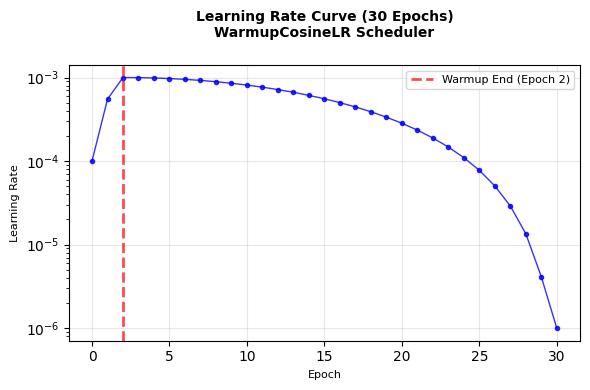


✅ Learning Rate 분석 완료!


In [3]:
# ==================== Learning Rate 변화 추적 및 시각화 ====================
import matplotlib.pyplot as plt
import numpy as np
import torch

print("=== Learning Rate 변화 분석 시작 ===")

# 더미 모델과 옵티마이저 생성 (실제 학습 설정과 동일하게)
print("📊 Learning Rate 변화 계산 중...")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(1, 1)
    def parameters(self):
        return [torch.nn.Parameter(torch.zeros(1))]

dummy_model = DummyModel()
optimizer = Make_Optimizer(dummy_model)
lr_scheduler = Make_LR_Scheduler(optimizer)

# 30 epoch 동안의 learning rate 변화 기록
epochs_list = []
lr_values = []

# 초기 learning rate 기록
current_lr = optimizer.param_groups[0]['lr']
epochs_list.append(0)
lr_values.append(current_lr)

# 각 epoch마다 scheduler step 실행하며 learning rate 기록
for epoch in range(1, epochs + 1):
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs_list.append(epoch)
    lr_values.append(current_lr)

print(f"✅ {epochs} epoch 동안의 Learning Rate 변화 계산 완료")

# Learning Rate 변화 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(epochs_list, lr_values, 'b-', linewidth=1, marker='o', markersize=3, alpha=0.8)
plt.title(f'Learning Rate Curve (30 Epochs)\n{lr_scheduler.__class__.__name__} Scheduler', 
          fontsize=10, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Learning Rate', fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 로그 스케일로 표시

# Warmup 구간 표시 (있는 경우)
if hasattr(lr_scheduler, 'warmup_iters') and lr_scheduler.warmup_iters > 0:
    warmup_epochs = lr_scheduler.warmup_iters
    plt.axvline(x=warmup_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Warmup End (Epoch {warmup_epochs})')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.close()  # 메모리 절약을 위해 close

print(f"\n✅ Learning Rate 분석 완료!")


In [4]:
now = datetime.now()
Experiments_Time=now.strftime("%y%m%d_%H%M%S")
print('Experiment Start Time:',Experiments_Time)
eval_columns=['Experiment Time','Train Time', 'Dataset Name', 'Model Name', 'Val Loss', 'Test Loss', 'IoU', 'Dice',  'Precision', 'Recall', 'Total Params','Train-Predction Time']
df = pd.DataFrame(index=None, columns=eval_columns)
output_root = f'{output_root}/output_{Experiments_Time}'
os.makedirs(output_root, exist_ok = True)
seed = iteration = 1
for j, Dataset_Name in enumerate(Dataset_Name_list):
    print(f'Dataset: {Dataset_Name} ({j+1}/{len(Dataset_Name_list)})')
    control_random_seed(seed)
    Dataset_dir = Dataset_root+'/'+Dataset_Name
    Height, Width = (256, 256)
    in_channels = 3
    number_of_classes = number_of_classes_dict[Dataset_Name]
    BINARY_SEG = True if number_of_classes==2 else False
    exclude_background = EXCLUDE_BACKGROUND
    out_channels = 1 if BINARY_SEG else number_of_classes

    train_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Originals/*"))
    train_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Masks/*"))
    validation_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Originals/*"))
    validation_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Masks/*"))
    test_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Originals/*"))
    test_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Masks/*"))
    print(f'train/val/test: {len(train_image_path_list)}/{len(validation_image_path_list)}/{len(test_image_path_list)}')

    # train_dataset = ImagesDataset(train_image_path_list, train_target_path_list, augment=False)
    train_dataset = ImagesDataset(train_image_path_list, train_target_path_list)
    validation_dataset = ImagesDataset(validation_image_path_list, validation_target_path_list)
    test_dataset = ImagesDataset(test_image_path_list, test_target_path_list)
    train_loader = SegDataLoader(
    train_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, shuffle=True, drop_last=True, fill_last_batch=False,
    )
    validation_loader = SegDataLoader(
        validation_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )
    test_loader = SegDataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )

    print(f'{model_name}', end=' ')
    print(f'Dataset: {Dataset_Name}) ({j+1}/{len(Dataset_Name_list)})', end=' ')
    output_dir = output_root + f'/{model_name}_{Dataset_Name}'
    control_random_seed(seed)
    model=globals()[model_name](in_channels, out_channels)
    model = model.to(device)
    optimizer = Make_Optimizer(model)
    lr_scheduler = Make_LR_Scheduler(optimizer)
    criterion = Make_Loss_Function(number_of_classes)
    if SAVE_RESULT==True:
        os.makedirs(vis_root+f"/{Dataset_Name}", exist_ok=True)
    df = Execute_Experiment(model_name, model, Dataset_Name, train_loader, validation_loader, test_loader, 
                            optimizer, lr_scheduler, criterion, number_of_classes, df, epochs, device, output_dir,
                           BINARY_SEG, exclude_background, out_channels, seed, THRESHOLD, EARLY_STOP, SAVE_RESULT, vis_root+f"/{Dataset_Name}", Experiments_Time
                           )
    df.to_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', index=False, header=True, encoding="cp949")

Experiment Start Time: 250616_225703
Dataset: ETIS (1/4)
train/val/test: 118/39/39
submission_20224258 Dataset: ETIS) (1/4) Training Start Time: 250616_225703


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

1EP(250616_225705): T_Loss: 0.992261 V_Loss: 0.989368 IoU: 0.0382 Best Epoch: 1 Loss: 0.989368


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

2EP(250616_225706): T_Loss: 0.978142 V_Loss: 0.984498 IoU: 0.0382 Best Epoch: 2 Loss: 0.984498


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

3EP(250616_225707): T_Loss: 0.958578 V_Loss: 0.964931 IoU: 0.0191 Best Epoch: 3 Loss: 0.964931


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

4EP(250616_225709): T_Loss: 0.943029 V_Loss: 0.947915 IoU: 0.0127 Best Epoch: 4 Loss: 0.947915


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

5EP(250616_225710): T_Loss: 0.932330 V_Loss: 0.937156 IoU: 0.0047 Best Epoch: 5 Loss: 0.937156


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

6EP(250616_225711): T_Loss: 0.925018 V_Loss: 0.923119 IoU: 0.0113 Best Epoch: 6 Loss: 0.923119


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

7EP(250616_225713): T_Loss: 0.919505 V_Loss: 0.912546 IoU: 0.0125 Best Epoch: 7 Loss: 0.912546


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

8EP(250616_225714): T_Loss: 0.914154 V_Loss: 0.908985 IoU: 0.0120 Best Epoch: 8 Loss: 0.908985


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

9EP(250616_225715): T_Loss: 0.908762 V_Loss: 0.906153 IoU: 0.0117 Best Epoch: 9 Loss: 0.906153


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

10EP(250616_225717): T_Loss: 0.904286 V_Loss: 0.903054 IoU: 0.0112 Best Epoch: 10 Loss: 0.903054


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

11EP(250616_225718): T_Loss: 0.900160 V_Loss: 0.897894 IoU: 0.0101 Best Epoch: 11 Loss: 0.897894


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

12EP(250616_225719): T_Loss: 0.895969 V_Loss: 0.895103 IoU: 0.0094 Best Epoch: 12 Loss: 0.895103


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

13EP(250616_225721): T_Loss: 0.893098 V_Loss: 0.893932 IoU: 0.0085 Best Epoch: 13 Loss: 0.893932


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

14EP(250616_225722): T_Loss: 0.889627 V_Loss: 0.886343 IoU: 0.0082 Best Epoch: 14 Loss: 0.886343


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

15EP(250616_225723): T_Loss: 0.886820 V_Loss: 0.882271 IoU: 0.0073 Best Epoch: 15 Loss: 0.882271


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

16EP(250616_225725): T_Loss: 0.883283 V_Loss: 0.884833 IoU: 0.0070 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

17EP(250616_225726): T_Loss: 0.880063 V_Loss: 0.876855 IoU: 0.0064 Best Epoch: 17 Loss: 0.876855


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

18EP(250616_225727): T_Loss: 0.878051 V_Loss: 0.878130 IoU: 0.0059 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

19EP(250616_225729): T_Loss: 0.876686 V_Loss: 0.873167 IoU: 0.0059 Best Epoch: 19 Loss: 0.873167


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

20EP(250616_225730): T_Loss: 0.874530 V_Loss: 0.874074 IoU: 0.0057 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

21EP(250616_225731): T_Loss: 0.872922 V_Loss: 0.870775 IoU: 0.0051 Best Epoch: 21 Loss: 0.870775


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

22EP(250616_225732): T_Loss: 0.871639 V_Loss: 0.871292 IoU: 0.0046 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

23EP(250616_225734): T_Loss: 0.870331 V_Loss: 0.871262 IoU: 0.0046 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

24EP(250616_225735): T_Loss: 0.869616 V_Loss: 0.869635 IoU: 0.0045 Best Epoch: 24 Loss: 0.869635


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

25EP(250616_225736): T_Loss: 0.868907 V_Loss: 0.869552 IoU: 0.0045 Best Epoch: 25 Loss: 0.869552


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

26EP(250616_225738): T_Loss: 0.868478 V_Loss: 0.868967 IoU: 0.0046 Best Epoch: 26 Loss: 0.868967


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

27EP(250616_225739): T_Loss: 0.869161 V_Loss: 0.867894 IoU: 0.0045 Best Epoch: 27 Loss: 0.867894


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

28EP(250616_225740): T_Loss: 0.868353 V_Loss: 0.867738 IoU: 0.0045 Best Epoch: 28 Loss: 0.867738


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

29EP(250616_225742): T_Loss: 0.867994 V_Loss: 0.867779 IoU: 0.0045 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

30EP(250616_225743): T_Loss: 0.867458 V_Loss: 0.867808 IoU: 0.0046 
Test Start Time: 250616_225743


Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Best Epoch: 28
Test(250616_225754): Loss: 0.865381 IoU: 0.0068 Dice: 0.0132 Precision: 0.0917 Recall: 0.0084
End 250616_225754
Dataset: CVPPP (2/4)
train/val/test: 486/162/162
submission_20224258 Dataset: CVPPP) (2/4) Training Start Time: 250616_225754


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

1EP(250616_225758): T_Loss: 0.904267 V_Loss: 0.885650 IoU: 0.0938 Best Epoch: 1 Loss: 0.885650


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

2EP(250616_225802): T_Loss: 0.869868 V_Loss: 0.854687 IoU: 0.4145 Best Epoch: 2 Loss: 0.854687


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

3EP(250616_225806): T_Loss: 0.840045 V_Loss: 0.820422 IoU: 0.3644 Best Epoch: 3 Loss: 0.820422


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

4EP(250616_225810): T_Loss: 0.815240 V_Loss: 0.800937 IoU: 0.6454 Best Epoch: 4 Loss: 0.800937


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

5EP(250616_225814): T_Loss: 0.797930 V_Loss: 0.783670 IoU: 0.8591 Best Epoch: 5 Loss: 0.783670


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

6EP(250616_225818): T_Loss: 0.779728 V_Loss: 0.766372 IoU: 0.8778 Best Epoch: 6 Loss: 0.766372


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

7EP(250616_225822): T_Loss: 0.763533 V_Loss: 0.751861 IoU: 0.8723 Best Epoch: 7 Loss: 0.751861


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

8EP(250616_225825): T_Loss: 0.747128 V_Loss: 0.734669 IoU: 0.8083 Best Epoch: 8 Loss: 0.734669


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

9EP(250616_225829): T_Loss: 0.734848 V_Loss: 0.726440 IoU: 0.8829 Best Epoch: 9 Loss: 0.726440


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

10EP(250616_225833): T_Loss: 0.723182 V_Loss: 0.716642 IoU: 0.8752 Best Epoch: 10 Loss: 0.716642


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

11EP(250616_225837): T_Loss: 0.711965 V_Loss: 0.703752 IoU: 0.8675 Best Epoch: 11 Loss: 0.703752


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

12EP(250616_225841): T_Loss: 0.702448 V_Loss: 0.713597 IoU: 0.7255 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

13EP(250616_225845): T_Loss: 0.696130 V_Loss: 0.686650 IoU: 0.8686 Best Epoch: 13 Loss: 0.686650


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

14EP(250616_225849): T_Loss: 0.687954 V_Loss: 0.684215 IoU: 0.8981 Best Epoch: 14 Loss: 0.684215


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

15EP(250616_225853): T_Loss: 0.683484 V_Loss: 0.677404 IoU: 0.9057 Best Epoch: 15 Loss: 0.677404


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

16EP(250616_225857): T_Loss: 0.680562 V_Loss: 0.675745 IoU: 0.9057 Best Epoch: 16 Loss: 0.675745


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

17EP(250616_225901): T_Loss: 0.675800 V_Loss: 0.672039 IoU: 0.9017 Best Epoch: 17 Loss: 0.672039


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

18EP(250616_225905): T_Loss: 0.674639 V_Loss: 0.669077 IoU: 0.9089 Best Epoch: 18 Loss: 0.669077


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

19EP(250616_225908): T_Loss: 0.671910 V_Loss: 0.667705 IoU: 0.8938 Best Epoch: 19 Loss: 0.667705


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

20EP(250616_225912): T_Loss: 0.669767 V_Loss: 0.666698 IoU: 0.9117 Best Epoch: 20 Loss: 0.666698


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

21EP(250616_225916): T_Loss: 0.669183 V_Loss: 0.665089 IoU: 0.9061 Best Epoch: 21 Loss: 0.665089


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

22EP(250616_225920): T_Loss: 0.668487 V_Loss: 0.664276 IoU: 0.9067 Best Epoch: 22 Loss: 0.664276


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

23EP(250616_225924): T_Loss: 0.666864 V_Loss: 0.664534 IoU: 0.8904 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

24EP(250616_225928): T_Loss: 0.668245 V_Loss: 0.663773 IoU: 0.9102 Best Epoch: 24 Loss: 0.663773


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

25EP(250616_225932): T_Loss: 0.666717 V_Loss: 0.662527 IoU: 0.9091 Best Epoch: 25 Loss: 0.662527


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

26EP(250616_225936): T_Loss: 0.666162 V_Loss: 0.662288 IoU: 0.9109 Best Epoch: 26 Loss: 0.662288


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

27EP(250616_225940): T_Loss: 0.664938 V_Loss: 0.662455 IoU: 0.9094 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

28EP(250616_225944): T_Loss: 0.665530 V_Loss: 0.661727 IoU: 0.9088 Best Epoch: 28 Loss: 0.661727


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

29EP(250616_225947): T_Loss: 0.665010 V_Loss: 0.661628 IoU: 0.9092 Best Epoch: 29 Loss: 0.661628


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

30EP(250616_225951): T_Loss: 0.664945 V_Loss: 0.661643 IoU: 0.9100 
Test Start Time: 250616_225951


Test:   0%|          | 0/11 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250616_230038): Loss: 0.665053 IoU: 0.9062 Dice: 0.9474 Precision: 0.9703 Recall: 0.9321
End 250616_230038
Dataset: CFD (3/4)
train/val/test: 70/24/24
submission_20224258 Dataset: CFD) (3/4) Training Start Time: 250616_230038


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

1EP(250616_230039): T_Loss: 1.003616 V_Loss: 1.002925 IoU: 0.0091 Best Epoch: 1 Loss: 1.002925


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

2EP(250616_230040): T_Loss: 0.993252 V_Loss: 1.002662 IoU: 0.0091 Best Epoch: 2 Loss: 1.002662


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

3EP(250616_230041): T_Loss: 0.973930 V_Loss: 0.998418 IoU: 0.0091 Best Epoch: 3 Loss: 0.998418


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

4EP(250616_230042): T_Loss: 0.960432 V_Loss: 0.999588 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

5EP(250616_230043): T_Loss: 0.954028 V_Loss: 0.994928 IoU: 0.0091 Best Epoch: 5 Loss: 0.994928


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

6EP(250616_230044): T_Loss: 0.949166 V_Loss: 0.987288 IoU: 0.0092 Best Epoch: 6 Loss: 0.987288


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

7EP(250616_230045): T_Loss: 0.944977 V_Loss: 0.978006 IoU: 0.0095 Best Epoch: 7 Loss: 0.978006


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

8EP(250616_230046): T_Loss: 0.941158 V_Loss: 0.966519 IoU: 0.0087 Best Epoch: 8 Loss: 0.966519


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

9EP(250616_230047): T_Loss: 0.937321 V_Loss: 0.954825 IoU: 0.0017 Best Epoch: 9 Loss: 0.954825


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

10EP(250616_230048): T_Loss: 0.934215 V_Loss: 0.945657 IoU: 0.0013 Best Epoch: 10 Loss: 0.945657


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

11EP(250616_230049): T_Loss: 0.930792 V_Loss: 0.939635 IoU: 0.0014 Best Epoch: 11 Loss: 0.939635


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

12EP(250616_230051): T_Loss: 0.928208 V_Loss: 0.933866 IoU: 0.0018 Best Epoch: 12 Loss: 0.933866


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

13EP(250616_230052): T_Loss: 0.926056 V_Loss: 0.933984 IoU: 0.0030 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

14EP(250616_230053): T_Loss: 0.923415 V_Loss: 0.930220 IoU: 0.0046 Best Epoch: 14 Loss: 0.930220


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

15EP(250616_230054): T_Loss: 0.921097 V_Loss: 0.928683 IoU: 0.0067 Best Epoch: 15 Loss: 0.928683


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

16EP(250616_230055): T_Loss: 0.919395 V_Loss: 0.925188 IoU: 0.0355 Best Epoch: 16 Loss: 0.925188


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

17EP(250616_230056): T_Loss: 0.917551 V_Loss: 0.923839 IoU: 0.0482 Best Epoch: 17 Loss: 0.923839


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

18EP(250616_230057): T_Loss: 0.916251 V_Loss: 0.920819 IoU: 0.0653 Best Epoch: 18 Loss: 0.920819


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

19EP(250616_230058): T_Loss: 0.914842 V_Loss: 0.918295 IoU: 0.0693 Best Epoch: 19 Loss: 0.918295


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

20EP(250616_230059): T_Loss: 0.913566 V_Loss: 0.916515 IoU: 0.0738 Best Epoch: 20 Loss: 0.916515


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

21EP(250616_230100): T_Loss: 0.912309 V_Loss: 0.914814 IoU: 0.0769 Best Epoch: 21 Loss: 0.914814


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

22EP(250616_230101): T_Loss: 0.911593 V_Loss: 0.913769 IoU: 0.0788 Best Epoch: 22 Loss: 0.913769


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

23EP(250616_230102): T_Loss: 0.911069 V_Loss: 0.912834 IoU: 0.0794 Best Epoch: 23 Loss: 0.912834


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

24EP(250616_230103): T_Loss: 0.910478 V_Loss: 0.912129 IoU: 0.0812 Best Epoch: 24 Loss: 0.912129


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

25EP(250616_230104): T_Loss: 0.910251 V_Loss: 0.911617 IoU: 0.0819 Best Epoch: 25 Loss: 0.911617


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

26EP(250616_230105): T_Loss: 0.910146 V_Loss: 0.910910 IoU: 0.0831 Best Epoch: 26 Loss: 0.910910


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

27EP(250616_230106): T_Loss: 0.909517 V_Loss: 0.910320 IoU: 0.0830 Best Epoch: 27 Loss: 0.910320


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

28EP(250616_230107): T_Loss: 0.909612 V_Loss: 0.910036 IoU: 0.0834 Best Epoch: 28 Loss: 0.910036


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

29EP(250616_230108): T_Loss: 0.909343 V_Loss: 0.909726 IoU: 0.0831 Best Epoch: 29 Loss: 0.909726


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

30EP(250616_230109): T_Loss: 0.909336 V_Loss: 0.909506 IoU: 0.0829 Best Epoch: 30 Loss: 0.909506
Test Start Time: 250616_230109


Test:   0%|          | 0/2 [00:00<?, ?batch/s]

Best Epoch: 30
Test(250616_230116): Loss: 0.908247 IoU: 0.0769 Dice: 0.1373 Precision: 0.0910 Recall: 0.3491
End 250616_230116
Dataset: CarDD (4/4)
train/val/test: 310/104/104
submission_20224258 Dataset: CarDD) (4/4) Training Start Time: 250616_230116


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

1EP(250616_230118): T_Loss: 0.947850 V_Loss: 0.928055 IoU: 0.1187 Best Epoch: 1 Loss: 0.928055


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

2EP(250616_230121): T_Loss: 0.923942 V_Loss: 0.925024 IoU: 0.1880 Best Epoch: 2 Loss: 0.925024


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

3EP(250616_230124): T_Loss: 0.897673 V_Loss: 0.888002 IoU: 0.1842 Best Epoch: 3 Loss: 0.888002


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

4EP(250616_230127): T_Loss: 0.878140 V_Loss: 0.870972 IoU: 0.1736 Best Epoch: 4 Loss: 0.870972


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

5EP(250616_230129): T_Loss: 0.864307 V_Loss: 0.854113 IoU: 0.1530 Best Epoch: 5 Loss: 0.854113


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

6EP(250616_230132): T_Loss: 0.852796 V_Loss: 0.845292 IoU: 0.1704 Best Epoch: 6 Loss: 0.845292


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

7EP(250616_230135): T_Loss: 0.842479 V_Loss: 0.826299 IoU: 0.0603 Best Epoch: 7 Loss: 0.826299


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

8EP(250616_230137): T_Loss: 0.832288 V_Loss: 0.824716 IoU: 0.1440 Best Epoch: 8 Loss: 0.824716


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

9EP(250616_230140): T_Loss: 0.822879 V_Loss: 0.817683 IoU: 0.0929 Best Epoch: 9 Loss: 0.817683


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

10EP(250616_230143): T_Loss: 0.814195 V_Loss: 0.803003 IoU: 0.0059 Best Epoch: 10 Loss: 0.803003


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

11EP(250616_230146): T_Loss: 0.806802 V_Loss: 0.803333 IoU: 0.0136 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

12EP(250616_230148): T_Loss: 0.800072 V_Loss: 0.792440 IoU: 0.0001 Best Epoch: 12 Loss: 0.792440


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

13EP(250616_230151): T_Loss: 0.793203 V_Loss: 0.788853 IoU: 0.0001 Best Epoch: 13 Loss: 0.788853


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

14EP(250616_230154): T_Loss: 0.786917 V_Loss: 0.777197 IoU: 0.0003 Best Epoch: 14 Loss: 0.777197


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

15EP(250616_230156): T_Loss: 0.782008 V_Loss: 0.777866 IoU: 0.0019 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

16EP(250616_230159): T_Loss: 0.777209 V_Loss: 0.769434 IoU: 0.0011 Best Epoch: 16 Loss: 0.769434


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

17EP(250616_230202): T_Loss: 0.773025 V_Loss: 0.768948 IoU: 0.0026 Best Epoch: 17 Loss: 0.768948


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

18EP(250616_230205): T_Loss: 0.769273 V_Loss: 0.763062 IoU: 0.0052 Best Epoch: 18 Loss: 0.763062


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

19EP(250616_230207): T_Loss: 0.766278 V_Loss: 0.764954 IoU: 0.0541 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

20EP(250616_230210): T_Loss: 0.763893 V_Loss: 0.761395 IoU: 0.0367 Best Epoch: 20 Loss: 0.761395


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

21EP(250616_230213): T_Loss: 0.761684 V_Loss: 0.761874 IoU: 0.0853 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

22EP(250616_230215): T_Loss: 0.759569 V_Loss: 0.757350 IoU: 0.0577 Best Epoch: 22 Loss: 0.757350


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

23EP(250616_230218): T_Loss: 0.758191 V_Loss: 0.756225 IoU: 0.0038 Best Epoch: 23 Loss: 0.756225


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

24EP(250616_230221): T_Loss: 0.757142 V_Loss: 0.758041 IoU: 0.0033 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

25EP(250616_230224): T_Loss: 0.756451 V_Loss: 0.755854 IoU: 0.0035 Best Epoch: 25 Loss: 0.755854


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

26EP(250616_230226): T_Loss: 0.756146 V_Loss: 0.754369 IoU: 0.0023 Best Epoch: 26 Loss: 0.754369


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

27EP(250616_230229): T_Loss: 0.755151 V_Loss: 0.755507 IoU: 0.0036 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

28EP(250616_230232): T_Loss: 0.755065 V_Loss: 0.754465 IoU: 0.0036 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

29EP(250616_230234): T_Loss: 0.754667 V_Loss: 0.753757 IoU: 0.0034 Best Epoch: 29 Loss: 0.753757


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

30EP(250616_230237): T_Loss: 0.754630 V_Loss: 0.754356 IoU: 0.0042 
Test Start Time: 250616_230237


Test:   0%|          | 0/7 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250616_230305): Loss: 0.755520 IoU: 0.0036 Dice: 0.0071 Precision: 0.3820 Recall: 0.0036
End 250616_230305


In [5]:
# 우회를 위한 prefix 제거
model_name = model_name.replace('submission_', '')

In [ ]:
# 결과 분석 및 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 읽기
results_df = pd.read_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', encoding='cp949')

print("\n=== 실험 결과 요약 ===")
print(f"모델: {results_df['Model Name'].unique()}")
print(f"\n=== 모델 파라미터 정보 ===")
if 'Total Params' in results_df.columns:
    total_params = results_df['Total Params'].iloc[1]  # 모든 실험에서 같은 모델 사용
    total_params = int(total_params.replace(',',''))
    print("총 파라미터 수: {:,}".format(total_params))

# 2. 각 데이터셋별 IoU 결과
print(f"\n=== 데이터셋별 IoU 결과 ===")
dataset_results = results_df[['Dataset Name', 'IoU', 'Dice', 'Precision', 'Recall']].copy()
dataset_results = dataset_results.round(4)
print(dataset_results.to_string(index=False))

# 3. Mean IoU 계산
mean_iou = results_df['IoU'].mean()
print(f"\n=== 전체 성능 요약 ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {results_df['Dice'].mean():.4f}")
print(f"Mean Precision: {results_df['Precision'].mean():.4f}")
print(f"Mean Recall: {results_df['Recall'].mean():.4f}")

# 상세 결과 테이블
print(f"\n=== 상세 실험 결과 ===")
display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
print(display_df.to_string(index=False))



=== 실험 결과 요약 ===
모델: ['submission_20224258']

=== 모델 파라미터 정보 ===
총 파라미터 수: 29,921

=== 데이터셋별 IoU 결과 ===
Dataset Name    IoU   Dice  Precision  Recall
        ETIS 0.0068 0.0132     0.0917  0.0084
       CVPPP 0.9062 0.9474     0.9703  0.9321
         CFD 0.0769 0.1373     0.0910  0.3491
       CarDD 0.0036 0.0071     0.3820  0.0036

=== 전체 성능 요약 ===
Mean IoU: 0.2484
Mean Dice: 0.2762
Mean Precision: 0.3838
Mean Recall: 0.3233

=== 상세 실험 결과 ===
Dataset Name          Model Name    IoU   Dice  Precision  Recall Total Params
        ETIS submission_20224258 0.0068 0.0132     0.0917  0.0084       29,921
       CVPPP submission_20224258 0.9062 0.9474     0.9703  0.9321       29,921
         CFD submission_20224258 0.0769 0.1373     0.0910  0.3491       29,921
       CarDD submission_20224258 0.0036 0.0071     0.3820  0.0036       29,921


In [7]:
# Global CSV에 결과 저장 (파라미터 사이즈와 Mean IoU만)
global_csv_path = 'results.csv'
global_result = {
    'Model_Name': [model_name],
    'Experiment_Time': [Experiments_Time],
    'Total_Params': [total_params],
    'Mean_IoU': [mean_iou]
}
global_df = pd.DataFrame(global_result)

# 기존 global CSV가 있으면 읽어서 추가, 없으면 새로 생성
if os.path.exists(global_csv_path):
    existing_global_df = pd.read_csv(global_csv_path)
    global_df = pd.concat([existing_global_df, global_df], ignore_index=True)

global_df.to_csv(global_csv_path, index=False)
print(f"\n=== Global 결과 저장 완료 ===")
print(f"저장 경로: {global_csv_path}")
print(f"누적 실험 수: {len(global_df)}")

# Global CSV 내용 확인
print(f"\n=== Global CSV 현재 내용 ===")
print(global_df.to_string(index=False))



=== Global 결과 저장 완료 ===
저장 경로: results.csv
누적 실험 수: 11

=== Global CSV 현재 내용 ===
Model_Name Experiment_Time  Total_Params  Mean_IoU
  Baseline   250612_020604       7763041  0.387735
  Baseline   250612_022650       7763041  0.385343
     LCNet   250612_031035        508258  0.258133
     LCNet   250612_032355        508258  0.274923
     LCNet   250612_033942        508258  0.179640
  Baseline   250612_232032       7763041  0.453180
    LEDNet   250613_004419        918105  0.120133
     SINet   250613_015805        212226  0.175864
     SINet   250613_021114        212226  0.150565
     LCNet   250616_184055        508258  0.244885
  20224258   250616_225703         29921  0.248373


In [8]:
# ==================== Core Metrics CSV 저장 ====================
# Core metrics를 별도 CSV로 저장
core_metrics_path = f'{output_root}/core_metrics_{Experiments_Time}.csv'

core_metrics_data = pd.DataFrame({
    'Student ID': [student_id],
    'Model Name': [model_name],
    'Experiment Time': [Experiments_Time],
    'Mean IoU': [round(mean_iou, 4)],
    'Total Params': [total_params]
})

core_metrics_data.to_csv(core_metrics_path, index=False, encoding='utf-8')
print(f"\n=== Core Metrics CSV 저장 완료 ===")
print(f"저장 경로: {core_metrics_path}")
print(f"\nCore Metrics 내용:")
print(core_metrics_data.to_string(index=False))

# ==================== Detail Metrics CSV 저장 ====================
# 상세 결과 테이블 출력
# Core metrics를 별도 CSV로 저장
detail_metrics_path = f'{output_root}/detail_metrics_{Experiments_Time}.csv'

display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
display_df['Total Params'] = display_df['Total Params'].str.replace(',','').astype(int)

display_df.to_csv(detail_metrics_path, index=False)
print(f"\n=== Detail Metrics CSV 저장 완료 ===")
print(f"저장 경로: {detail_metrics_path}")
print(f"\nDetail Metrics 내용:")
print(display_df.to_string(index=False))


=== Core Metrics CSV 저장 완료 ===
저장 경로: output/output_250616_225703/core_metrics_250616_225703.csv

Core Metrics 내용:
Student ID Model Name Experiment Time  Mean IoU  Total Params
  20224258   20224258   250616_225703    0.2484         29921

=== Detail Metrics CSV 저장 완료 ===
저장 경로: output/output_250616_225703/detail_metrics_250616_225703.csv

Detail Metrics 내용:
Dataset Name          Model Name    IoU   Dice  Precision  Recall  Total Params
        ETIS submission_20224258 0.0068 0.0132     0.0917  0.0084         29921
       CVPPP submission_20224258 0.9062 0.9474     0.9703  0.9321         29921
         CFD submission_20224258 0.0769 0.1373     0.0910  0.3491         29921
       CarDD submission_20224258 0.0036 0.0071     0.3820  0.0036         29921


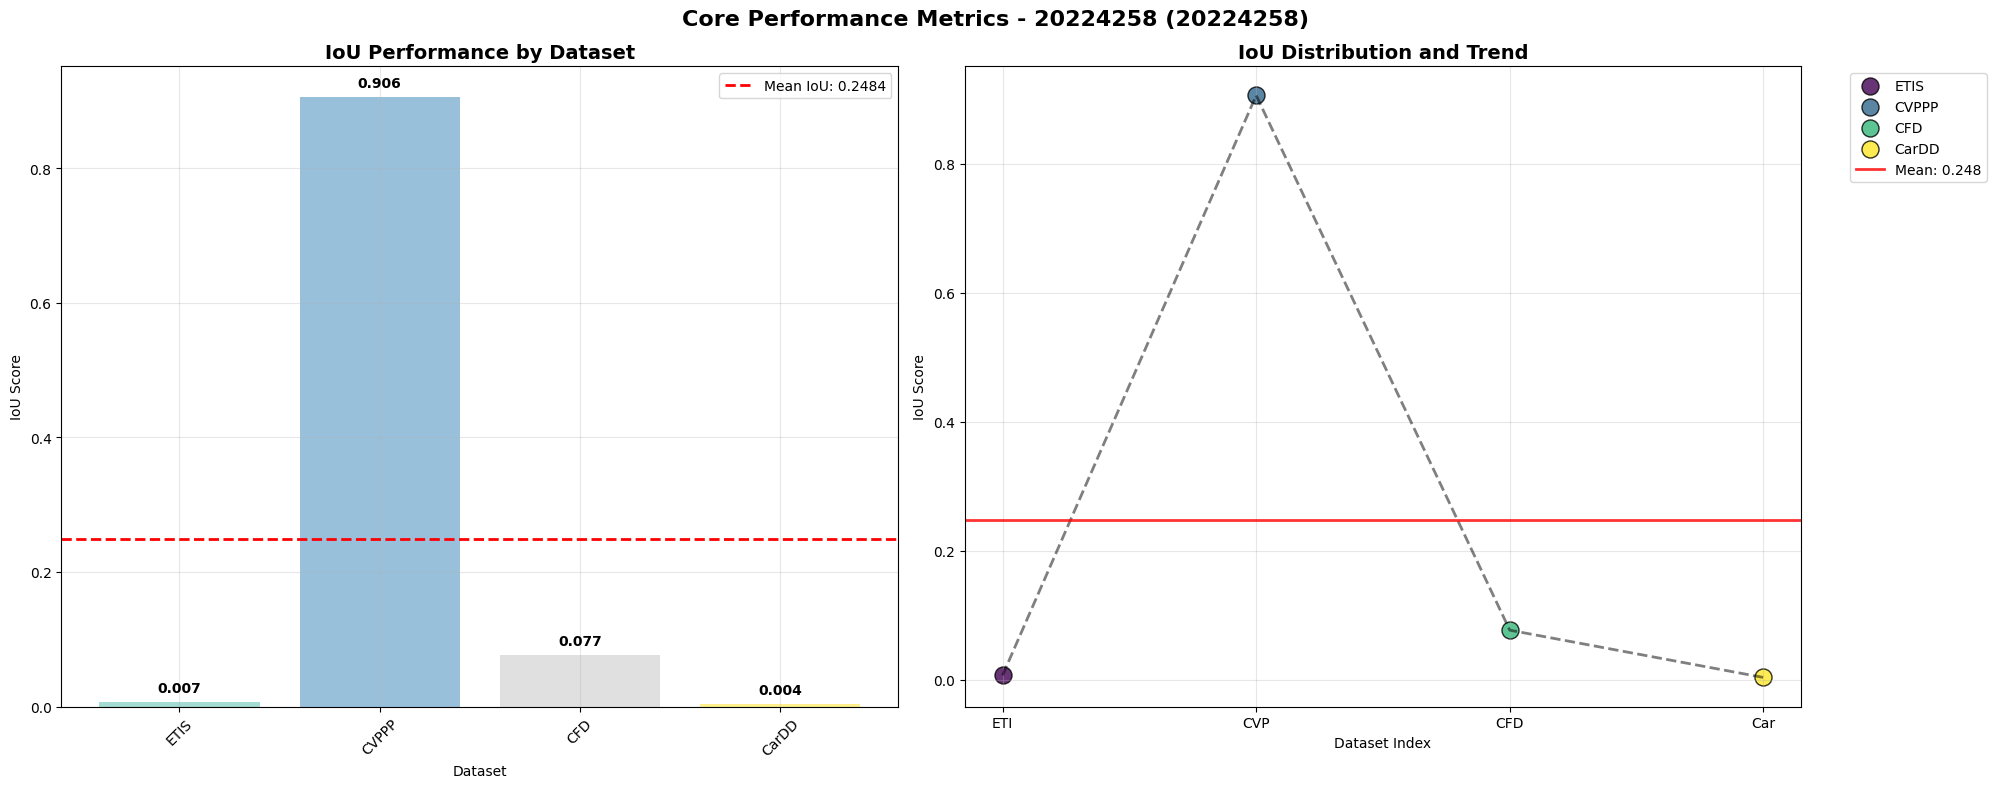

In [9]:
# ==================== 첫 번째 장: 핵심 지표 시각화 ====================
plt.figure(figsize=(20, 8))
plt.suptitle(f'Core Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 1-1. 각 데이터셋별 IoU (바 차트)
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Dataset Name'], results_df['IoU'], color=colors, alpha=0.8)
plt.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
plt.title('IoU Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, results_df['IoU']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 1-2. IoU 분포 (레이더 차트 스타일)
plt.subplot(1, 2, 2)
datasets = results_df['Dataset Name'].tolist()
iou_scores = results_df['IoU'].tolist()

# 색상 맵 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for i, (dataset, iou, color) in enumerate(zip(datasets, iou_scores, colors)):
    plt.scatter(i, iou, s=150, c=[color], alpha=0.8, label=dataset, edgecolors='black', linewidth=1)

plt.plot(range(len(datasets)), iou_scores, 'k--', alpha=0.5, linewidth=2)
plt.axhline(y=mean_iou, color='red', linestyle='-', alpha=0.8, linewidth=2,
            label=f'Mean: {mean_iou:.3f}')
plt.title('IoU Distribution and Trend', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Index')
plt.ylabel('IoU Score')
plt.xticks(range(len(datasets)), [d[:3] for d in datasets])  # 줄여서 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'core_performance_{Experiments_Time}.png')
plt.show()

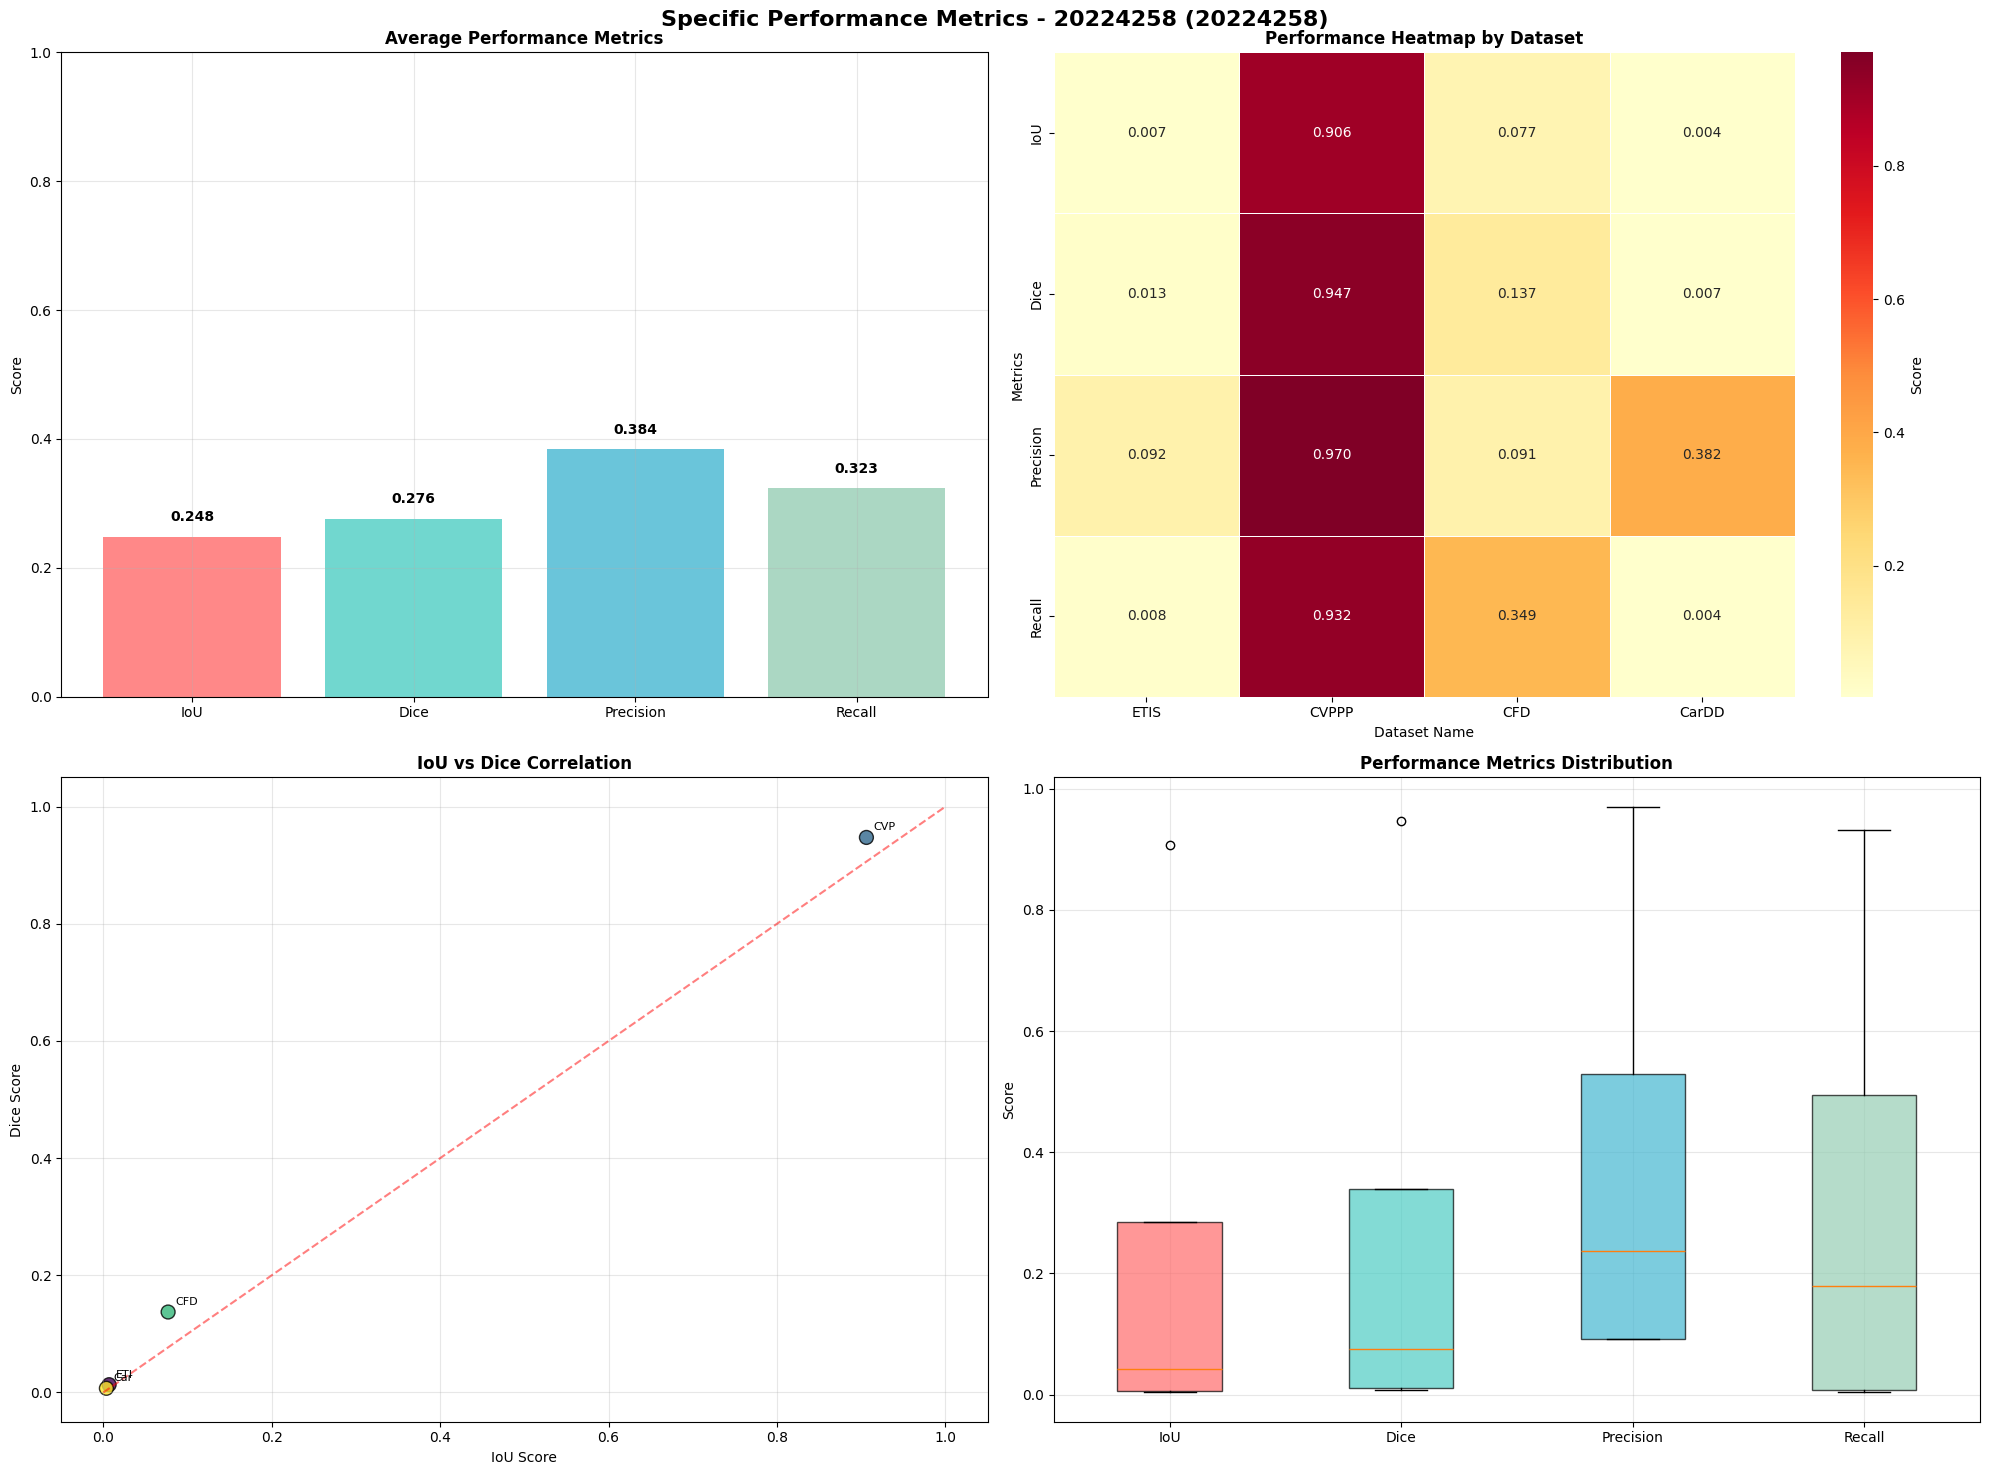

In [10]:
# ==================== 두 번째 장: 상세 분석 ====================
plt.figure(figsize=(20, 15))
plt.suptitle(f'Specific Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 2-1. 전체 성능 지표 비교
plt.subplot(2, 2, 1)
metrics = ['IoU', 'Dice', 'Precision', 'Recall']
values = [results_df[metric].mean() for metric in metrics]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Average Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2-2. 데이터셋별 성능 히트맵
plt.subplot(2, 2, 2)
heatmap_data = results_df[['IoU', 'Dice', 'Precision', 'Recall']].T
heatmap_data.columns = results_df['Dataset Name']

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Heatmap by Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Metrics')

# 2-3. IoU vs Dice 상관관계
plt.subplot(2, 2, 3)
plt.scatter(results_df['IoU'], results_df['Dice'], c=range(len(results_df)), 
           cmap='viridis', s=100, alpha=0.8, edgecolors='black')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # 대각선
plt.xlabel('IoU Score')
plt.ylabel('Dice Score')
plt.title('IoU vs Dice Correlation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 각 점에 데이터셋 이름 표시
for i, dataset in enumerate(results_df['Dataset Name']):
    plt.annotate(dataset[:3], (results_df['IoU'].iloc[i], results_df['Dice'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2-4. 성능 지표별 분포
plt.subplot(2, 2, 4)
metrics_data = []
metrics_labels = []
for metric in ['IoU', 'Dice', 'Precision', 'Recall']:
    metrics_data.append(results_df[metric].tolist())
    metrics_labels.append(metric)

box_plot = plt.boxplot(metrics_data, labels=metrics_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Performance Metrics Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'detail_performance_{Experiments_Time}.png')
plt.show()


In [11]:
# === 마지막 셀: 실험 내역 요약 & Markdown 저장 (샘플 이미지, 그래프, Core/Detail CSV 테이블 포함) ===
import glob, importlib.util, torch
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd

# 1) Performance Metrics
metrics_summary = {
    'Mean IoU': mean_iou,
    'Mean Dice': results_df['Dice'].mean(),
    'Mean Precision': results_df['Precision'].mean(),
    'Mean Recall': results_df['Recall'].mean(),
    'Total Params': total_params
}

# 2) 샘플 이미지 (최대 4개)
sample_images = glob.glob(f"{vis_root}/*/*.png")[:4]

# 3) 분석용 그래프 이미지 (output_root/*.png)
graph_images = glob.glob(f"{output_root}/*.png")

# 4) Core & Detail CSV 경로 자동 탐색
csv_files = glob.glob(f"{output_root}/*.csv")
core_csv_path   = next((p for p in csv_files if 'core'   in Path(p).name.lower()), None)
detail_csv_path = next((p for p in csv_files if 'detail' in Path(p).name.lower()), None)

# 5) CSV 읽기
core_df   = pd.read_csv(core_csv_path)   if core_csv_path   else pd.DataFrame()
detail_df = pd.read_csv(detail_csv_path) if detail_csv_path else pd.DataFrame()

# 6) training_args.py 동적 로드
spec = importlib.util.spec_from_file_location('training_args', 'training_args.py')
training_args = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_args)

# 7) 더미 모델 생성 후 옵티마이저/스케줄러/손실 함수 인스턴스
class _Dummy(torch.nn.Module):
    def parameters(self): return [torch.nn.Parameter(torch.zeros(1))]
dummy = _Dummy()
opt     = training_args.Make_Optimizer(dummy)
sch     = training_args.Make_LR_Scheduler(opt)

# Binary와 Multiclass 두 경우 모두 생성
loss_fn_binary = training_args.Make_Loss_Function(2)    # Binary case (클래스 수 = 2)
loss_fn_multi  = training_args.Make_Loss_Function(21)   # Multiclass case (VOC 21클래스)

# 8) 하이퍼파라미터 추출
opt_params = {k: v for k,v in opt.defaults.items() if k in ('lr','momentum','weight_decay','betas','eps')}
sch_params = {
    'type':      sch.__class__.__name__,
    'T_max':     getattr(sch, 'T_max', None),
    'warmup':    getattr(sch, 'warmup_iters', None),
    'eta_min':   getattr(sch, 'eta_min', None),
    'power':     getattr(sch, 'power', None),
}
# Binary와 Multiclass loss function 정보 추출
def extract_loss_params(loss_fn, case_name):
    params = {'type': loss_fn.__class__.__name__, 'case': case_name}
    for attr in ('alpha','gamma','weight','ignore_index','mode'):
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params

loss_params_binary = extract_loss_params(loss_fn_binary, 'Binary (2 classes)')
loss_params_multi = extract_loss_params(loss_fn_multi, 'Multiclass (21 classes)')

# 9) Markdown 조립
md_lines = [
    '# 📝 실험 내역 요약',
    '## ▶ Performance Metrics'
]
for k,v in metrics_summary.items():
    if k == 'Total Params':
        md_lines.append(f"- **{k}**: `{v:,}`")  # 쉼표 형식으로 표시
    else:
        md_lines.append(f"- **{k}**: `{v:.4f}`")

# 그래프 이미지
md_lines += ['', '## ▶ 분석용 그래프']
for img in graph_images:
    img_name = Path(img).name
    md_lines.append(f"![{img_name}]({img_name})")

# Core CSV 테이블
if not core_df.empty:
    md_lines += ['', '## ▶ Core Metrics']
    # DataFrame.to_markdown() 로 생성된 텍스트를 한 줄씩 추가
    md_lines += core_df.to_markdown(index=False).split('\n')

# Detail CSV 테이블
if not detail_df.empty:
    md_lines += ['', '## ▶ Detail Metrics']
    md_lines += detail_df.to_markdown(index=False).split('\n')

# Hyperparameters
md_lines += ['', '## ▶ Hyperparameters']
md_lines.append(f"### Optimizer ({opt.__class__.__name__})")
for k,v in opt_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"### Scheduler ({sch_params.pop('type')})")
for k,v in sch_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

# Loss Functions (Binary & Multiclass)
md_lines.append("### Loss Functions")

md_lines.append(f"#### Binary Case ({loss_params_binary.pop('type')})")
for k,v in loss_params_binary.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"#### Multiclass Case ({loss_params_multi.pop('type')})")
for k,v in loss_params_multi.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_text = '\n'.join(md_lines)

# 10) 화면에 출력
#display(Markdown(md_text))

# 11) Markdown 파일로 저장
output_dir = Path(output_root)
output_dir.mkdir(parents=True, exist_ok=True)
md_path = output_dir / f"experiment_summary_{Experiments_Time}.md"
md_path.write_text(md_text, encoding='utf-8')

print(f"✅ Markdown 요약이 저장되었습니다: {md_path}")


✅ Markdown 요약이 저장되었습니다: output/output_250616_225703/experiment_summary_250616_225703.md
